# Simple Harmonic Motion
## Lecture 7

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interactive, fixed

Physical systems with regular, repeating motion are said to be *periodic*.

If an objects undergoes periodic motion between two limits over the same path, we call the motion *oscillitory*.

Examples of oscillitory motion:
- plucked guitar string
- pendulum of a grandfather clock
- oscillations of atoms in crystalline solids



## Spring-mass system

<a title="No machine-readable author provided. LucasVB assumed (based on copyright claims). [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Harmonic_oscillator.svg"><img width="256" alt="Harmonic oscillator" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Harmonic_oscillator.svg/256px-Harmonic_oscillator.svg.png"></a>

A block of mass $m$ is connected to the free end of spring with spring constant $k$.

### Hooke's Law

The spring exerts a force on the block proportional to its displacement from equilibrium.

$$F_{spring} = -k x$$

### Newton's Law

From Newton's Second Law we can write down an equation of motion for the block:

$$\frac{d^2 x}{d t^2} = - \frac{k}{m} x = -\omega_0^2 x$$

where the angular frequency $\omega_0$ is defined by

$$ \omega_0^2 = \frac{k}{m}.$$

The dynamical behaviour of such as system is called *simple harmonic motion*.

It has known analytical solutions in terms of sine and cosine functions.  One form of the solution is

$$ x(t) = A \cos (\omega_0 t + \phi)$$

where $A$ and $\phi$ are constants and the argument of the cosine is in radians.

#### Constants

- $A$ amplitude
- $\phi$ phase

Because cosine is a periodic function with period $2\pi$ we know that $x(t)$ is also periodic.

*Period*, $T$, is the smallest time for which the motion repeats itself,

$$x(t+T) = x(t).$$

Since $\omega_0 T$ corresponds to one cycle,

$$ T = \frac{2\pi}{\omega_0} = \frac{2\pi}{\sqrt{k/m}}$$


*Frequency*, $\nu$, is the number of cycles per second,

$$ \nu = \frac{1}{T} = \frac{\sqrt{k/m}}{2\pi}$$

Notice that period and frequency do *not* depend on $A$ or $\phi$ but only on the ratio $k/m$.

## Numerical Solution

As we have now done several times, we can also solve this problem numerically. Our algorithm, Euler's method, tells us

$$\begin{align} 
x(t + \Delta t) &= x(t) + v(t) \Delta t \\
v(t + \Delta t) &= v(t) + a(t) \Delta t 
\end{align}
$$

So let's code up a simple application that solves for an oscilliator undergoing simple harmonic motion (SHM).

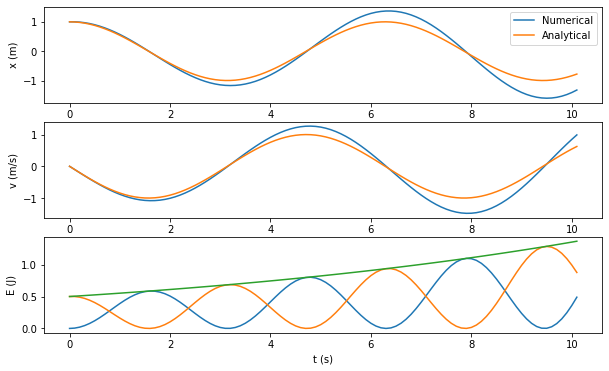

In [3]:
# constants
k = 1
m = 1

def SHMEulerStepper(x0=1, v0=0, dt=0.1, tmax=10):
    """
    Solve for the simple harmonic motion of a mass-spring system using Euler's method
    
    x is the position
    v is the velocity
    """
    
    # initialize the model
    t = 0
    x = x0
    v = v0
    
    while True:
        model = {'t': t, 'x': x, 'v': v}
        yield model # return the model state back to the caller
    
        if t > tmax:
            break
        
        # calculate acceleration (force / mass)
        a = - k/m * x 
        
        # use the Euler algorithm to update the state of the model
        
        x = x + v * dt
        v = v + a * dt
        
        t = t + dt
        
def SHMPlotter(data):
    fig, axs = plt.subplots(3, 1, figsize=(10,6))
    
    axs[0].plot(data.t, data.x, label='Numerical')
    axs[0].plot(data.t, np.cos(data.t), label='Analytical')
    axs[0].set_ylabel("x (m)")
    axs[0].legend()
    
    axs[1].plot(data.t, data.v)
    axs[1].plot(data.t, -np.sin(data.t))
    axs[1].set_ylabel("v (m/s)")
    
    KE = 1/2 * m * data.v**2
    PE = 1/2 * k * data.x**2
    E = KE + PE
    axs[2].plot(data.t, KE)
    axs[2].plot(data.t, PE)
    axs[2].plot(data.t, E)
    axs[2].set_ylabel("E (J)")
    
    axs[2].set_xlabel("t (s)")

    
def SHMEulerApp(tmax=10, dt=0.1):
    stepper = SHMEulerStepper(tmax=tmax, dt=dt)
    data = pd.DataFrame(stepper)
    SHMPlotter(data)
    return data
    
data = SHMEulerApp()

Even thought the position and velocity are constantly changing the total energy $E$ should remain a constant.

$$ E = \frac{1}{2}m v^2 + \frac{1}{2} k x^2 = \frac{1}{2} k A^2 $$

where the two terms are the kinetic and potential energy.

- - -
##### Exercise

Uncomment the code above to show the plots of the kinetic, potential, and total energies over time.
- - -

Something is going wrong here. Energy should be conserved yet this numerical model is predicting that energy is increasing.

Over time, the mass will start oscillating more and more as shown by the following interactive widget:

In [4]:
interactive(SHMEulerApp, tmax=(2, 40, 2), dt=fixed(0.1))

interactive(children=(IntSlider(value=10, description='tmax', max=40, min=2, step=2), Output()), _dom_classes=…

We have not made a mistake in the physics. The problem here is with the numerical method.

As we have discussed, using a finite difference is a *approximation* to a real derivative. Every time step Euler's method introduces a small error to the solution. Over time, this error grows.

We can see that this error is directly related to the size of the time step.

In [5]:
interactive(SHMEulerApp, dt=(0.02, 0.2, 0.02), tmax=fixed(10))

interactive(children=(FloatSlider(value=0.1, description='dt', max=0.2, min=0.02, step=0.02), Output()), _dom_…

It turns out that, for Euler's method, the error is linearly proportional to the time step $\Delta t$.

The reason the numerical method is not working is that that Euler's method assume that the velocity and acceleration do not change too much during the time step $\Delta t$. To get an acceptable numerical result we need to choose $\Delta t$ to be sufficiently small.

But making $\Delta t$ too small leads to new problems:
- computer time increase for the program to finish
- round-off error due to finite precision of floating points numerics will accumulate
- Euler's method is unstable for many problems causing errors to grow exponentially

### Modified Euler Algorithms

#### Euler-Cromer algorithm

Euler's method is

$$\begin{align} 
x(t + \Delta t) &= x(t) + v(t) \Delta t \\
v(t + \Delta t) &= v(t) + a(t) \Delta t 
\end{align}
$$

We can make a very simple change and write

$$\begin{align} 
x(t + \Delta t) &= x(t) + v(t+\Delta t) \Delta t \\
v(t + \Delta t) &= v(t) + a(t) \Delta t 
\end{align}
$$

This modified Euler's method is called the Euler-Cromer algorithm. The only difference is the computed velocity at the end of the interval, $v(t + \Delta t)$ is used to compute the new position $x(t + \Delta t)$.

In [6]:
def SHMEulerCromerStepper(x0=1, v0=0, dt=0.1, tmax=10):
    """
    Solve for the simple harmonic motion of a mass-spring system using Euler-Crommer
    
    x is the position
    v is the velocity
    """
    
    # initialize the model
    t = 0
    x = x0
    v = v0
    
    while True:
        model = {'t': t, 'x': x, 'v': v}
        yield model # return the model state back to the caller
    
        if t > tmax:
            break
            
        # calculate acceleration (force / mass)
        a = - k/m * x
        
        # use the Euler-Cromer algorithm to update the state of the model
        v = v + a * dt
        x = x + v * dt
        t = t + dt

    
def SHMEulerCromerApp(tmax=10, dt=0.1):
    stepper = SHMEulerCromerStepper(tmax=tmax, dt=dt)
    data = pd.DataFrame(stepper)
    SHMPlotter(data)
    return data
    
interactive(SHMEulerCromerApp, tmax=(2, 40, 2), dt=(0.01, 0.2, 0.02))

interactive(children=(IntSlider(value=10, description='tmax', max=40, min=2, step=2), FloatSlider(value=0.1, d…

The only change made to the code (besides changes the name `SHMEuler` to `SHMEulerCromer`) was to flip the order of the statements from

```
        x = x + v * dt
        v = v + a * dt
```

to become

```
        v = v + a * dt
        x = x + v * dt
```

With this modified Euler method, we first updating the velocity `v` and then using that to update the position `x`.

In the Euler-Cromer method, energy (when averaged over one period of an oscillation) is conserved. This energy conservation is a key property of the numerical stability of this new method.

#### Euler-Richardson algorithm

Rathering the computing the velocity at the beginning or the end of each interval, it is even better to compute the velocity and acceleration and the mid-point of each interval. This is the *Euler-Richardson* algorithm and is especially useful when the forces depend on velocity.

Euler's method is used to find an intermediate position $x_{mid}$ and velocity $v_{mid}$ at a time $t_mid = t + \Delta t/2$.

We can then compute the force, $F(x_{mid}, v_{mid}, t_{mid})$ and the acceleration $a_{mid}$ at $t = t_{mid}$.

The new position $x_{n+1}$ and velocity $v_{n+1}$ at time $t_{n+1}$ are then found using $v_{mid}$ and $a_{mid}$ with the Euler algorithm.

The Euler-Richardson algorithm is:

$$\begin{align}
a_n &= F(x_n, v_n, t_n) /  m \\
v_{mid} &= v_n + \frac{1}{2} a_n \Delta t \\
x_{mid} &= x_n + \frac{1}{2} v_n \Delta t \\
a_{mid} &= F(x_{mid}, v_{mid}, t + \frac{1}{2} \Delta t) / m
\end{align}
$$

and

$$\begin{align}
v_{n+1} &= v_n + a_{mid} \Delta t \\
x_{n+1} &= x_n + v_{mid} \Delta t 
\end{align}
$$

In [7]:
def SHMEulerRichardsonStepper(x0=1, v0=0, dt=0.1, tmax=10):
    """
    Solve for the simple harmonic motion of a mass-spring system using Euler-Richardson
    
    x is the position
    v is the velocity
    """
    
    # initialize the model
    t = 0
    x = x0
    v = v0
    
    while True:
        model = {'t': t, 'x': x, 'v': v}
        yield model # return the model state back to the caller
    
        if t > tmax:
            break
            
        # calculate acceleration (force / mass)
        a = - k/m * x 
        
        # use the Euler-Richardson algorithm to update the state of the model
        vmid = v + 1/2 * a * dt
        xmid = x + 1/2 * v * dt
        amid = - k/m * xmid
        
        v = v + amid * dt
        x = x + vmid * dt
        t = t + dt
    
def SHMEulerRichardsonApp(tmax=10, dt=0.1):
    stepper = SHMEulerRichardsonStepper(tmax=tmax, dt=dt)
    data = pd.DataFrame(stepper)
    SHMPlotter(data)
    return data
    
interactive(SHMEulerRichardsonApp, tmax=(2, 40, 2), dt=(0.01, 0.2, 0.02))

interactive(children=(IntSlider(value=10, description='tmax', max=40, min=2, step=2), FloatSlider(value=0.1, d…

Even thought the Euler-Richardson algorithm requires twice as many calculations per time step, we can take use much larger values of $\Delta t$ and still obtain better accuracy that either the Euler or Euler-Cromer algorithms.

- - -
### Textbook readings

- CSM 4.1 Simple Harmonic Motion
- CSM 3.1 Modified Euler Algorithms

### DataCamp exercises

To learn more about Python, work through the following [DataCamp](http://datacamp.com) chapters:
- Introduction to Python: Python Basics
- Introduction to Python: Functions and Packages 
- Introduction to Python: NumPy 
- Intermediate Python for Data Science: Matplotlib 
- Intermediate Python for Data Science: Logic, Control Flow and Filtering 
- Intermediate Python for Data Science: Loops

These tutorials remains available until the end of the course.

### Assignment 2

You should be working on Assignment 2 now (due Sunday Sept. 29).  Those two problems are taken directly from the textbook, so reviewing the textbook could be useful. Also, you probably want to start from the code we developed in the corresponding lectures.

Please let me know if you want to meet to discuss this assignment via Zoom either 1-on-1 or with a group.

### Lab 2

Please ask for help!